In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import time
import seaborn as sns

from sklearn import preprocessing
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split # Import train_test_split function
import joblib
import warnings
warnings.filterwarnings("ignore")

from sklearn.ensemble import RandomForestClassifier

from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import completeness_score, homogeneity_score, v_measure_score

In [2]:
for name in glob.glob('cicids2017/*.csv'):
    print(name)

cicids2017\Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv
cicids2017\Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv
cicids2017\Friday-WorkingHours-Morning.pcap_ISCX.csv
cicids2017\Monday-WorkingHours.pcap_ISCX.csv
cicids2017\Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv
cicids2017\Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv
cicids2017\Tuesday-WorkingHours.pcap_ISCX.csv
cicids2017\Wednesday-workingHours.pcap_ISCX.csv


In [4]:
# Define the path to your directory containing the CSV files
path = "cicids2017"

# Get all CSV files in the specified directory
all_files = glob.glob(path + "/*.csv")

# Concatenate all CSV files into a single DataFrame with index reset
dataset = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)

In [5]:
dataset.columns = dataset.columns.str.strip()
dataset.columns

Index(['Destination Port', 'Flow Duration', 'Total Fwd Packets',
       'Total Backward Packets', 'Total Length of Fwd Packets',
       'Total Length of Bwd Packets', 'Fwd Packet Length Max',
       'Fwd Packet Length Min', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s',
       'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
       'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
       'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags',
       'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length',
       'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s',
       'Min Packet Length', 'Max Packet Length', 'Packet Length Mean',
       'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count',
       'SYN Flag Co

In [6]:
# check all the values are numerical
# if not, would have to encode
dataset.dtypes.unique()

array([dtype('int64'), dtype('float64'), dtype('O')], dtype=object)

In [7]:
# Get columns by data type
int_cols = dataset.select_dtypes(include='int64').columns
float_cols = dataset.select_dtypes(include='float64').columns
object_cols = dataset.select_dtypes(include='O').columns

# Print the column names for each type
print("Integer columns:", int_cols)
print("Float columns:", float_cols)
print("Object columns:", object_cols)

Integer columns: Index(['Destination Port', 'Flow Duration', 'Total Fwd Packets',
       'Total Backward Packets', 'Total Length of Fwd Packets',
       'Total Length of Bwd Packets', 'Fwd Packet Length Max',
       'Fwd Packet Length Min', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Flow IAT Max', 'Flow IAT Min',
       'Fwd IAT Total', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total',
       'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags',
       'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length',
       'Bwd Header Length', 'Min Packet Length', 'Max Packet Length',
       'FIN Flag Count', 'SYN Flag Count', 'RST Flag Count', 'PSH Flag Count',
       'ACK Flag Count', 'URG Flag Count', 'CWE Flag Count', 'ECE Flag Count',
       'Down/Up Ratio', 'Fwd Header Length.1', 'Fwd Avg Bytes/Bulk',
       'Fwd Avg Packets/Bulk', 'Fwd Avg Bulk Rate', 'Bwd Avg Bytes/Bulk',
       'Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate', 'Subflow Fwd Packets',
       'Subflow Fwd 

In [8]:
#drop 'Fwd Header Length.1' it repeated with different names

dataset = dataset.drop(columns=['Fwd Header Length.1'])

dataset.columns.duplicated()


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False])

In [9]:
dataset.isnull().any().any()

np.True_

In [10]:
# Remove rows with NaN, Null, or Inf values
dataset = dataset.replace([np.inf, -np.inf], np.nan).dropna()

# Reset the index after removing rows
dataset = dataset.reset_index(drop=True)

#double check
dataset.isnull().any().any()

np.False_

In [11]:
col_names = dataset.columns
# Initialize a list to store columns to drop
to_drop = []

# Iterate over each column
for col in col_names:
    # Check if the column has only one unique value
    if dataset[col].nunique() == 1:
        to_drop.append(col)

to_drop

['Bwd PSH Flags',
 'Bwd URG Flags',
 'Fwd Avg Bytes/Bulk',
 'Fwd Avg Packets/Bulk',
 'Fwd Avg Bulk Rate',
 'Bwd Avg Bytes/Bulk',
 'Bwd Avg Packets/Bulk',
 'Bwd Avg Bulk Rate']

In [12]:
dataset = dataset.drop(columns=to_drop)

In [13]:
#remove unicode chars

dataset.loc[dataset.Label == "Web Attack � Brute Force", ['Label']] = "Web Brute Force"
dataset.loc[dataset.Label == "Web Attack � XSS", ['Label']] = "XSS"
dataset.loc[dataset.Label == "Web Attack � Sql Injection", ['Label']] = "Sql Injection"

In [14]:
# Convert 'BENIGN' label to 0 and any other label to 1
dataset['Binary_Label'] = dataset['Label'].apply(lambda x: 0 if x == 'BENIGN' else 1)

In [15]:
from sklearn.model_selection import train_test_split

# Three labeling options
attacks = ['Label', 'Binary_Label']

# Feature vectors (xs) and labels (ys)
xs = dataset.drop(attacks, axis=1)
ys = dataset[attacks]

# Stratified split: 60% training, 20% testing, 20% validation
x_train, x_test, y_train, y_test = train_test_split(xs, ys, test_size=0.2, random_state=0, stratify=ys['Label'])


# Print the shapes of the splits to verify
print(f"x_train shape: {x_train.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

print(f"dataset shape: {dataset.shape}")

x_train shape: (2262300, 69)
x_test shape: (565576, 69)
y_train shape: (2262300, 2)
y_test shape: (565576, 2)
dataset shape: (2827876, 71)


In [26]:
from sklearn.preprocessing import MinMaxScaler
# Normalise
min_max_scaler = MinMaxScaler().fit(x_train)
joblib.dump(min_max_scaler, 'min_max_scaler.joblib')
# Apply normalisation to dataset
x_train = min_max_scaler.transform(x_train)
x_test = min_max_scaler.transform(x_test)

# All values between 0 and 1
pd.Series(x_train.flatten()).describe()

count    1.560987e+08
mean     8.702987e-02
std      2.501023e-01
min      0.000000e+00
25%      0.000000e+00
50%      7.773460e-07
75%      6.410256e-03
max      1.000000e+00
dtype: float64

In [40]:
from sklearn.ensemble import RandomForestClassifier
# Initialize the RandomForestClassifier
classifier= RandomForestClassifier(random_state=0)

In [41]:
# Fit the model and measure training time
start = time.time()
classifier.fit(x_train, y_train.Binary_Label)
end = time.time()
training_time = end - start



In [42]:
# Predict on the validation set and measure prediction time
start = time.time()
y_predicted = classifier.predict(x_test)
end = time.time()
predict_time = end - start

# Print the training and prediction times
print(f"Training time: {training_time:.4f} seconds")
print(f"Prediction time: {predict_time:.4f} seconds")

Training time: 640.9727 seconds
Prediction time: 4.0931 seconds


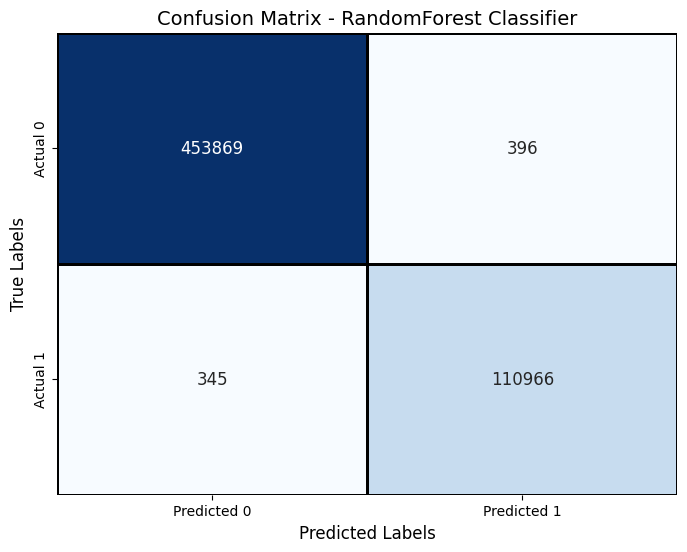

In [43]:
# Create a confusion matrix
conf_matrix = confusion_matrix(y_test.Binary_Label, y_predicted)
confusion_rf_3 = pd.DataFrame(conf_matrix, index=['Actual 0', 'Actual 1'], columns=['Predicted 0', 'Predicted 1'])

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_rf_3, annot=True, fmt='d', cmap='Blues', cbar=False, linewidths=1, linecolor='black', annot_kws={'size': 12})
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)
plt.title('Confusion Matrix - RandomForest Classifier', fontsize=14)
plt.show()

In [44]:
precision, recall, fscore, support = score(y_test.Binary_Label, y_predicted)
d = {'attack': [0,1], 'precision': precision, 'recall' : recall, 'fscore': fscore, 'support':support}
results = pd.DataFrame(data=d)
results

,attack,precision,recall,fscore,support
0,0,0.999240,0.999128,0.999184,454265
1,1,0.996444,0.996901,0.996672,111311


In [50]:
joblib.dump(classifier, 'random_forest_model.pkl')

['random_forest_model.pkl']

In [45]:
df = pd.read_csv('cicids2017/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv')

df.columns = df.columns.str.strip()
df = df.drop(columns=['Fwd Header Length.1'])

dataset['Binary_Label'] = dataset['Label'].apply(lambda x: 0 if x == 'BENIGN' else 1)

# Three labeling options
attacks = ['Label', 'Binary_Label']


# Remove rows with NaN, Null, or Inf values
df = df.replace([np.inf, -np.inf], np.nan).dropna()

# Reset the index after removing rows
df = df.reset_index(drop=True)


# Feature vectors (xs) and labels (ys)
xs = dataset.drop(attacks, axis=1)
ys = dataset[attacks]


scaler = MinMaxScaler()
xs = scaler.fit_transform(xs)


In [46]:
# Predict on the validation set and measure prediction time
start = time.time()
y_predicted = classifier.predict(xs)
end = time.time()
predict_time = end - start


print(f"Prediction time: {predict_time:.4f} seconds")

Prediction time: 16.8116 seconds


In [47]:
precision, recall, fscore, support = score(ys.Binary_Label, y_predicted)
d = {'attack': [0,1], 'precision': precision, 'recall' : recall, 'fscore': fscore, 'support':support}
results = pd.DataFrame(data=d)
results

,attack,precision,recall,fscore,support
0,0,0.998923,0.999265,0.999094,2271320
1,1,0.996995,0.995602,0.996298,556556


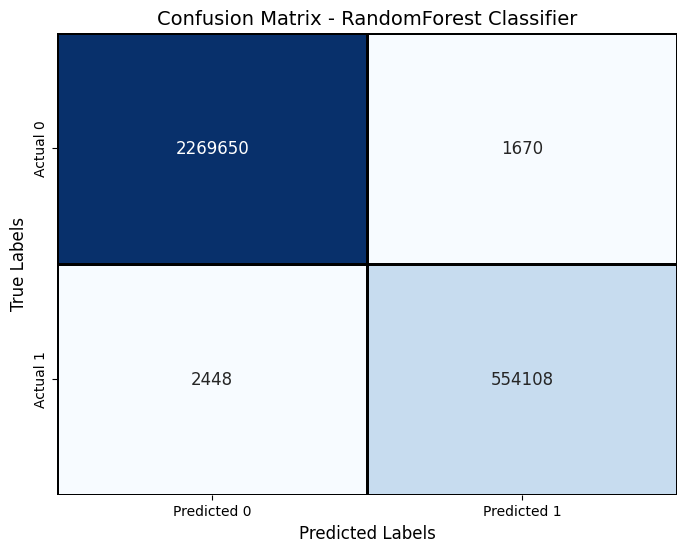

In [49]:
# Create a confusion matrix
conf_matrix = confusion_matrix(ys.Binary_Label, y_predicted)
confusion_rf_3 = pd.DataFrame(conf_matrix, index=['Actual 0', 'Actual 1'], columns=['Predicted 0', 'Predicted 1'])

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_rf_3, annot=True, fmt='d', cmap='Blues', cbar=False, linewidths=1, linecolor='black', annot_kws={'size': 12})
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)
plt.title('Confusion Matrix - RandomForest Classifier', fontsize=14)
plt.show()